In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [7]:
POS_PATH

'data\\positive'

In [8]:
!tar -xf lfw.tgz

In [5]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [8]:
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\42837b94-f577-11ec-ace7-b803058baf19.jpg'

In [31]:
os.listdir('lfw')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [11]:
frame

array([[[149, 175, 155],
        [155, 181, 160],
        [160, 186, 163],
        ...,
        [190, 178, 166],
        [192, 176, 169],
        [191, 175, 165]],

       [[150, 176, 156],
        [159, 182, 162],
        [164, 185, 165],
        ...,
        [187, 177, 170],
        [188, 175, 174],
        [186, 174, 172]],

       [[151, 176, 151],
        [157, 182, 161],
        [160, 185, 167],
        ...,
        [185, 176, 178],
        [184, 175, 178],
        [182, 175, 177]],

       ...,

       [[ 40,  58,  72],
        [ 42,  60,  76],
        [ 46,  61,  80],
        ...,
        [ 54,  71,  68],
        [ 53,  70,  69],
        [ 57,  69,  78]],

       [[ 38,  59,  70],
        [ 42,  63,  77],
        [ 46,  61,  80],
        ...,
        [ 48,  67,  76],
        [ 49,  67,  81],
        [ 52,  67,  87]],

       [[ 32,  60,  73],
        [ 40,  63,  82],
        [ 49,  62,  88],
        ...,
        [ 48,  67,  82],
        [ 51,  69,  84],
        [ 50,  68,  83]]

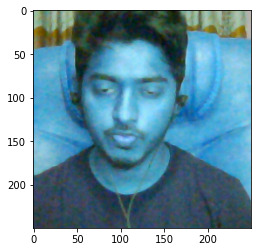

In [12]:
plt.imshow(frame)

In [45]:
frame[:250, :250, :].shape

(250, 250, 3)

In [46]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [47]:
import os
import uuid

In [48]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [49]:
dir_test = anchor.as_numpy_iterator()

In [50]:
print(dir_test.next())

b'data\\anchor\\26b006fa-f3ff-11ec-b5b5-b803058baf19.jpg'


In [51]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [52]:
img = preprocess('data\\anchor\\26b006fa-f3ff-11ec-b5b5-b803058baf19.jpg')

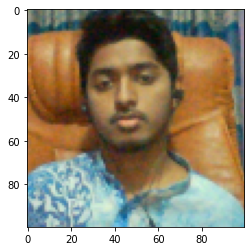

In [53]:
plt.imshow(img)

In [54]:
img.numpy().min() 

0.0

In [55]:
img.numpy().max() 

0.9610294

In [56]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [57]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [58]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [59]:
samples = data.as_numpy_iterator()

In [60]:
example = samples.next()

In [61]:
example

(b'data\\anchor\\51787b38-f577-11ec-9da0-b803058baf19.jpg',
 b'data\\positive\\03258e68-f3fe-11ec-a877-b803058baf19.jpg',
 1.0)

In [62]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [63]:
res = preprocess_twin(*exampple)

NameError: name 'exampple' is not defined

In [64]:
plt.imshow(res[1])

NameError: name 'res' is not defined

In [65]:
res[2]

NameError: name 'res' is not defined

In [66]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [67]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [68]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [69]:
inp = Input(shape=(100,100,3), name='input_image')

In [70]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [71]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [72]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [73]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [74]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [75]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [76]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [77]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [78]:
embedding = make_embedding()

In [79]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

In [80]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [81]:
l1 = L1Dist()

In [82]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined